#### Showcase its capabilities

In [17]:
from autoencoders import AutoEncoder
import tinygrad
from tinygrad import Tensor
from tinygrad.dtype import dtypes
import numpy as np
from tqdm import tqdm

In [18]:
from tinygrad.helpers import fetch
import gzip

# taken from tinygrad.extra.datasets:
def fetch_mnist(tensors=False):
  parse = lambda file: np.frombuffer(gzip.open(file).read(), dtype=np.uint8).copy()
  BASE_URL = "https://storage.googleapis.com/cvdf-datasets/mnist/"   # http://yann.lecun.com/exdb/mnist/ lacks https
  X_train = parse(fetch(f"{BASE_URL}train-images-idx3-ubyte.gz"))[0x10:].reshape((-1, 28*28)).astype(np.float32)
  Y_train = parse(fetch(f"{BASE_URL}train-labels-idx1-ubyte.gz"))[8:].astype(np.int8)
  X_test = parse(fetch(f"{BASE_URL}t10k-images-idx3-ubyte.gz"))[0x10:].reshape((-1, 28*28)).astype(np.float32)
  Y_test = parse(fetch(f"{BASE_URL}t10k-labels-idx1-ubyte.gz"))[8:].astype(np.int8)
  if tensors: return Tensor(X_train).reshape(-1, 1, 28, 28), Tensor(Y_train), Tensor(X_test).reshape(-1, 1, 28, 28), Tensor(Y_test)
  else: return X_train, Y_train, X_test, Y_test

X_train, Y_train, X_test, Y_test = fetch_mnist()
X_train, X_test = X_train/255.0, X_test/255.0
len(X_train), len(X_test)


(60000, 10000)

In [49]:
import matplotlib.pyplot as plt

def show_autoencoder(autoencoder, true_imgs: np.ndarray):
    plt.figure(figsize=(20, 20//(len(true_imgs)/2)))

    for i, true_img in enumerate(true_imgs):
        processed_img = autoencoder(Tensor(true_img, requires_grad=False)).numpy()
        
        plt.subplot(2, len(true_imgs), i+1)
        plt.imshow(true_img.reshape(28, 28))
        plt.title('True Image', fontsize = 8)

        plt.subplot(2, len(true_imgs), i+len(true_imgs)+1)
        plt.imshow(processed_img.reshape(28, 28))
        plt.title('Processed', fontsize = 8)
        
    plt.tight_layout()
    plt.show()

In [50]:
autoencoder = AutoEncoder(784, 128, 10)
opt = tinygrad.nn.optim.SGD([layer.weight for layer in autoencoder.encoder.layers] + [layer.weight for layer in autoencoder.decoder.layers], lr=1e-4)

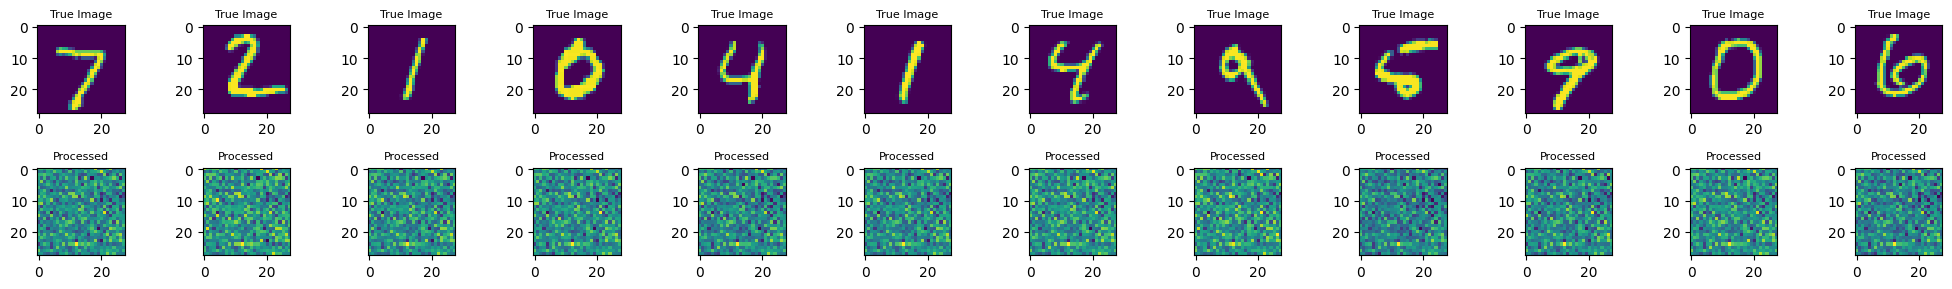

In [53]:
show_autoencoder(autoencoder, X_test[:12])

In [54]:
nsteps = 76000
batch_size = 16

steps = []
losses = []
evals = []

def sparse_categorical_crossentropy(x, y):
    z = ((x - y)**2).sum(axis=1).sum(axis=0)
    return z

def eval(autoencoder, X_test):
    losses = []
    for _ in range(20):
        samp = np.random.randint(0, X_train.shape[0], size=(batch_size))
        batch = Tensor(X_train[samp], requires_grad=False)
        labels = Tensor(X_train[samp])

        out = autoencoder(batch)
        losses.append(sparse_categorical_crossentropy(out, labels))
    return (sum(losses) / len(losses)).numpy()

In [55]:
with Tensor.train():
  for step in tqdm(range(nsteps)):
    # random sample a batch
    samp = np.random.randint(0, X_train.shape[0], size=(batch_size))
    batch = Tensor(X_train[samp], requires_grad=False)
    labels = Tensor(X_train[samp])

    out = autoencoder(batch)
    loss = sparse_categorical_crossentropy(out, labels)

    opt.zero_grad()
    loss.backward()
    opt.step()

    if step % 100 == 0:
      steps.append(step)
      losses.append(loss.numpy())
      evals.append(eval(autoencoder, X_test))

print("Equivalent number of epochs trained for: ", nsteps * batch_size / X_train.shape[0])

100%|██████████| 76000/76000 [08:50<00:00, 143.26it/s]

Equivalent number of epochs trained for:  20.266666666666666


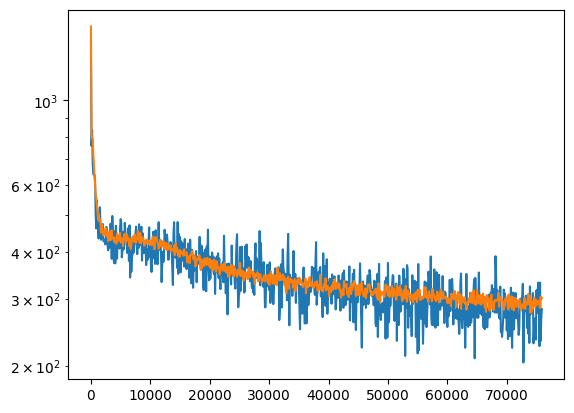

In [58]:
plt.semilogy(steps, losses, label="train loss")
plt.semilogy(steps, evals, label="eval loss")

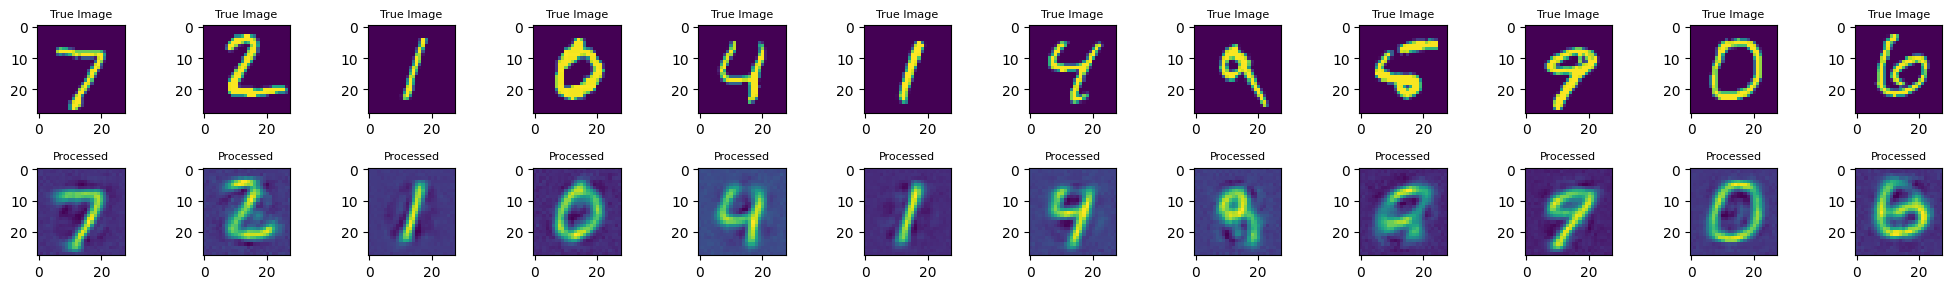

In [59]:
show_autoencoder(autoencoder, X_test[:12])